This notebook follows the case study example from https://github.com/cybera/case-study-example/blob/main/EDA_ookla_dataset.ipynb

In [ ]:
# Current version is only exploratory.
# Need to re-do this process by:
## yearly & quarterly data.
## grouping methods other than the municipalities.


In [42]:
# Install and import modules

!pip install geopandas rtree pysal --quiet
import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
from shapely.geometry import Polygon
import os
import pysal # PySAL: python Spatial Analysis Library
import mapclassify as mc
import matplotlib.pyplot as plt
import pickle
os.chdir('/content/drive/MyDrive/shared/2022-ssc-case-comp/ssc22-case-comp/dataset/')
print(os.getcwd())

/content/drive/MyDrive/shared/2022-ssc-case-comp/ssc22-case-comp/dataset


In [ ]:
## Load data
province = 'Alberta'
year_quarter = '2019-Q1'
#file_path = '../../dataset/'+province + '/' + province + '-speed-tiles.shp'
file_path = './' + province + '/by_year_quarter/' + province + '-' + year_quarter + '.shp'
# print(file_path)
data = gpd.read_file(file_path)
data.head(5)

## Check if we have the right province data
print(data['PRNAME'].unique())
print(data.shape)
print(data.columns)

['Alberta']
(28018, 21)
Index(['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices',
       'year', 'quarter', 'conn_type', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME',
       'DAUID', 'SACTYPE', 'DA_POP', 'PCUID', 'PCNAME', 'PCTYPE', 'PCCLASS',
       'geometry'],
      dtype='object')


In [ ]:
# change the crs of our data
ab_data = data.to_crs(4326)
ab_data.head(5)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,...,CDUID,CDNAME,DAUID,SACTYPE,DA_POP,PCUID,PCNAME,PCTYPE,PCCLASS,geometry
0,0210303330011222,8339,10131,43,1,1,2019,Q1,fixed,48,...,4817,Division No. 17,48170204,6,135.0,None,None,None,None,"POLYGON ((-118.69629 59.15622, -118.69080 59.1..."
1,0210312023201010,3063,3104,45,1,1,2019,Q1,fixed,48,...,4817,Division No. 17,48170204,6,135.0,None,None,None,None,"POLYGON ((-117.71851 59.62333, -117.71301 59.6..."
2,0210312023201131,1072,1154,52,2,1,2019,Q1,fixed,48,...,4817,Division No. 17,48170204,6,135.0,None,None,None,None,"POLYGON ((-117.69104 59.61777, -117.68555 59.6..."
3,0210312032031301,1000,1240,47,2,1,2019,Q1,fixed,48,...,4817,Division No. 17,48170204,6,135.0,None,None,None,None,"POLYGON ((-117.26257 59.65664, -117.25708 59.6..."
4,0210312032303210,705,1202,47,1,1,2019,Q1,fixed,48,...,4817,Division No. 17,48170204,6,135.0,None,None,None,None,"POLYGON ((-117.19116 59.58998, -117.18567 59.5..."


In [ ]:
# Municipal boundaries data downloaded from Altalis.com
print(os.getcwd())
counties = gpd.read_file('./Alberta/municipal_boundaries/')
ab_counties = counties.to_crs(4326)

/content/drive/MyDrive/shared/2022-ssc-case-comp/ssc22-case-comp/dataset


In [ ]:
# check whether the crs of the two maps match
ab_data.crs == ab_counties.crs

True

In [ ]:
# Join our data to Municipalities
data_in_ab_counties = gpd.sjoin(ab_data, ab_counties, how='inner', predicate='intersects')

# Convert kbps --> Mbps for easier reading
data_in_ab_counties['avg_d_mbps'] = data_in_ab_counties['avg_d_kbps']/1000
data_in_ab_counties['avg_u_mbps'] = data_in_ab_counties['avg_u_kbps']/1000

data_in_ab_counties.head(5)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,...,PCTYPE,PCCLASS,geometry,index_right,RURAL_ID,PID,GEONAME,GEOCODE,avg_d_mbps,avg_u_mbps
0,0210303330011222,8339,10131,43,1,1,2019,Q1,fixed,48,...,None,None,"POLYGON ((-118.69629 59.15622, -118.69080 59.1...",71,72,29837,MACKENZIE COUNTY,0505,8.339,10.131
1,0210312023201010,3063,3104,45,1,1,2019,Q1,fixed,48,...,None,None,"POLYGON ((-117.71851 59.62333, -117.71301 59.6...",71,72,29837,MACKENZIE COUNTY,0505,3.063,3.104
2,0210312023201131,1072,1154,52,2,1,2019,Q1,fixed,48,...,None,None,"POLYGON ((-117.69104 59.61777, -117.68555 59.6...",71,72,29837,MACKENZIE COUNTY,0505,1.072,1.154
3,0210312032031301,1000,1240,47,2,1,2019,Q1,fixed,48,...,None,None,"POLYGON ((-117.26257 59.65664, -117.25708 59.6...",71,72,29837,MACKENZIE COUNTY,0505,1.000,1.240
4,0210312032303210,705,1202,47,1,1,2019,Q1,fixed,48,...,None,None,"POLYGON ((-117.19116 59.58998, -117.18567 59.5...",71,72,29837,MACKENZIE COUNTY,0505,0.705,1.202


In [ ]:
# check columns
data_in_ab_counties.columns

Index(['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices',
       'year', 'quarter', 'conn_type', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME',
       'DAUID', 'SACTYPE', 'DA_POP', 'PCUID', 'PCNAME', 'PCTYPE', 'PCCLASS',
       'geometry', 'index_right', 'RURAL_ID', 'PID', 'GEONAME', 'GEOCODE',
       'avg_d_mbps', 'avg_u_mbps'],
      dtype='object')

In [9]:
# Define w_avg()

def w_avg(df, name_col, val_cols, w_col='tests'):
    """ Computes weighted averages of specified columns"""
    '''
    df: target data frame.
    name_col: String. The grouping column.
    val_cols: list of strings. Names of the columns to average over.
    w_col: String. Name of the column that is used for weighting the averages.
    '''
    
    names = df[name_col].unique()
    col_list = [name_col, val_cols[0], val_cols[1], val_cols[2], w_col]
    result_df = pd.DataFrame(columns = col_list)    
    for name in names:
        # extract a group
        temp_table = df[df[name_col]==name] 
        # compute the weightes averages
        temp_d_avg = np.average(temp_table[val_cols[0]], weights=temp_table[w_col])
        temp_u_avg = np.average(temp_table[val_cols[1]], weights=temp_table[w_col])
        temp_l_avg = np.average(temp_table[val_cols[2]], weights=temp_table[w_col])
        temp_w = np.sum(temp_table[w_col])
        # add the averages to the result dataframe
        result_df = result_df.append(dict(zip(col_list, [name, temp_d_avg, temp_u_avg, temp_l_avg, temp_w])), ignore_index=True)
    return result_df

# test run 
# test_df = data_in_ab_counties.head(10000)
# w_avg(test_df, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')


In [ ]:
# Obtain grouped data wtih weighted average
w_data = w_avg(data_in_ab_counties, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')
w_data

,GEONAME,avg_d_mbps,avg_u_mbps,avg_lat_ms,tests
0,MACKENZIE COUNTY,15.963290,5.951960,41.996835,632
1,CLEAR HILLS COUNTY,13.558198,10.469837,34.755814,86
2,SADDLE HILLS COUNTY,23.984379,8.865031,53.287179,195
3,MUNICIPAL DISTRICT OF SPIRIT RIVER NO. 133,13.097157,3.021382,36.147059,102
4,MUNICIPAL DISTRICT OF FAIRVIEW NO. 136,9.024851,2.818930,92.326984,315
...,...,...,...,...,...
72,SPECIAL AREAS NO. 3,10.870726,2.759589,50.232877,73
73,MUNICIPAL DISTRICT OF ACADIA NO. 34,15.226083,12.358333,30.250000,12
74,CYPRESS COUNTY,108.552099,14.082712,22.863737,4506
75,COUNTY OF FORTY MILE NO. 8,28.028960,6.461581,43.590062,322


In [ ]:
# Map for the download speeds in rural municipalities

# Prepare data
county_data = ab_counties[['GEONAME', 'geometry']].merge(w_data, on='GEONAME').to_crs(3401)

county_data1 = county_data.copy()
labels1 = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]
county_data['group'] = pd.cut(county_data1['avg_d_mbps'], (0, 25, 50, 100, 150, 200), right=False, labels = labels1)

county_data2 = county_data.copy()
labels2 = ["<50 Mbps", ">=50 Mbps"]
county_data2['group'] = pd.cut(county_data2['avg_d_mbps'], (0, 50, 200), right=False, labels = labels2)

county_data2.head(5)

,GEONAME,geometry,avg_d_mbps,avg_u_mbps,avg_lat_ms,tests,group
0,MUNICIPAL DISTRICT OF ACADIA NO. 34,"POLYGON ((344970.316 5689257.335, 344990.382 5...",15.226083,12.358333,30.250000,12,<50 Mbps
1,ATHABASCA COUNTY,"POLYGON ((85005.230 6041573.042, 84992.850 604...",17.806554,5.089200,77.816327,686,<50 Mbps
2,COUNTY OF BARRHEAD NO. 11,"POLYGON ((62247.933 5973395.463, 62250.428 597...",43.036290,8.962070,54.260952,525,<50 Mbps
3,BEAVER COUNTY,"POLYGON ((133169.531 5904503.862, 133159.357 5...",14.202453,4.190582,90.922570,607,<50 Mbps
4,MUNICIPAL DISTRICT OF BONNYVILLE NO. 87,"POLYGON ((321095.689 6077372.165, 321097.120 6...",53.919985,13.736475,60.374059,1727,>=50 Mbps


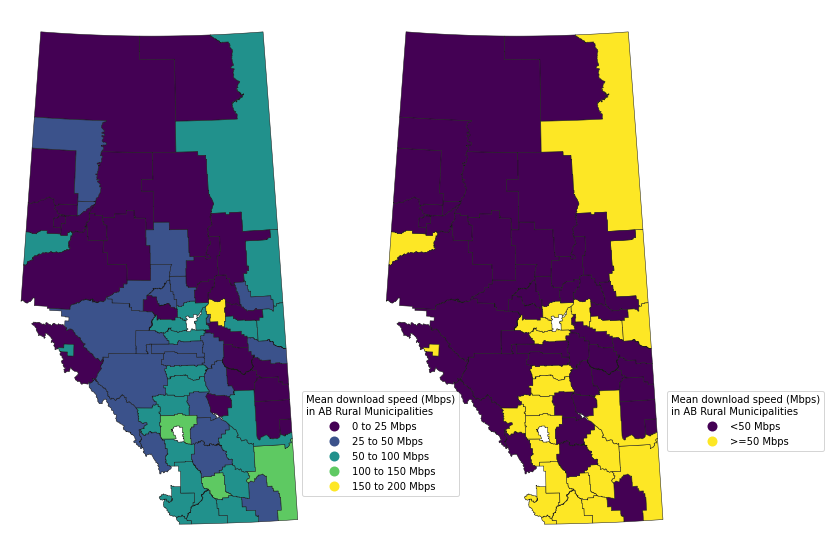

In [ ]:
# produce the map for the download speed
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 20))

# Detailed map
county_data.plot(column='group', cmap='viridis', linewidth=0.5, ax=ax1, edgecolor='0.1', legend=True)
ax1.axis('off')
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1.5, 0.3))
leg.set_title('Mean download speed (Mbps)\nin AB Rural Municipalities')

# Less detailed map
county_data2.plot(column='group', cmap='viridis', linewidth=0.5, ax=ax2, edgecolor='0.1', legend=True)
ax2.axis('off')
leg = ax2.get_legend()
leg.set_bbox_to_anchor((1.5, 0.3))
leg.set_title('Mean download speed (Mbps)\nin AB Rural Municipalities')


In [41]:
# Now iterate over other quarters.

##### Data prep stage ####

i_yq_data = {} # placeholder for the geoDataFrames

province = 'Alberta'
province_short = 'AB'
years = ['2019', '2020', '2021']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

counties = gpd.read_file('./Alberta/municipal_boundaries/')
ab_counties = counties.to_crs(4326)

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        
        yq = str(year) + '-' + str(quarter)

        i_file_path = './' + province + '/by_year_quarter/' + province + '-' + yq + '.shp'
        i_data = gpd.read_file(i_file_path)
        i_ab_data = i_data.to_crs(4326)

        i_joint_data = gpd.sjoin(i_ab_data, ab_counties, how='inner', predicate='intersects')
        # Convert kbps --> Mbps for easier reading
        i_joint_data['avg_d_mbps'] = i_joint_data['avg_d_kbps']/1000
        i_joint_data['avg_u_mbps'] = i_joint_data['avg_u_kbps']/1000

        i_w_data = w_avg(i_joint_data, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')

        i_county_data = ab_counties[['GEONAME', 'geometry']].merge(i_w_data, on='GEONAME').to_crs(3401)
        
        labels1 = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]
        i_county_data['group1'] = pd.cut(i_county_data['avg_d_mbps'], (0, 25, 50, 100, 150, 200), right=False, labels = labels1)
        
        labels2 = ["<50 Mbps", ">=50 Mbps"]
        i_county_data['group2'] = pd.cut(i_county_data['avg_d_mbps'], (0, 50, 200), right=False, labels = labels2)

        i_yq_data[yq] = i_county_data
        

In [43]:
with open('./Alberta/AB_yq_data_by_municipalities.p', 'wb') as f:
    pickle.dump(i_yq_data, f)
print('save complete')

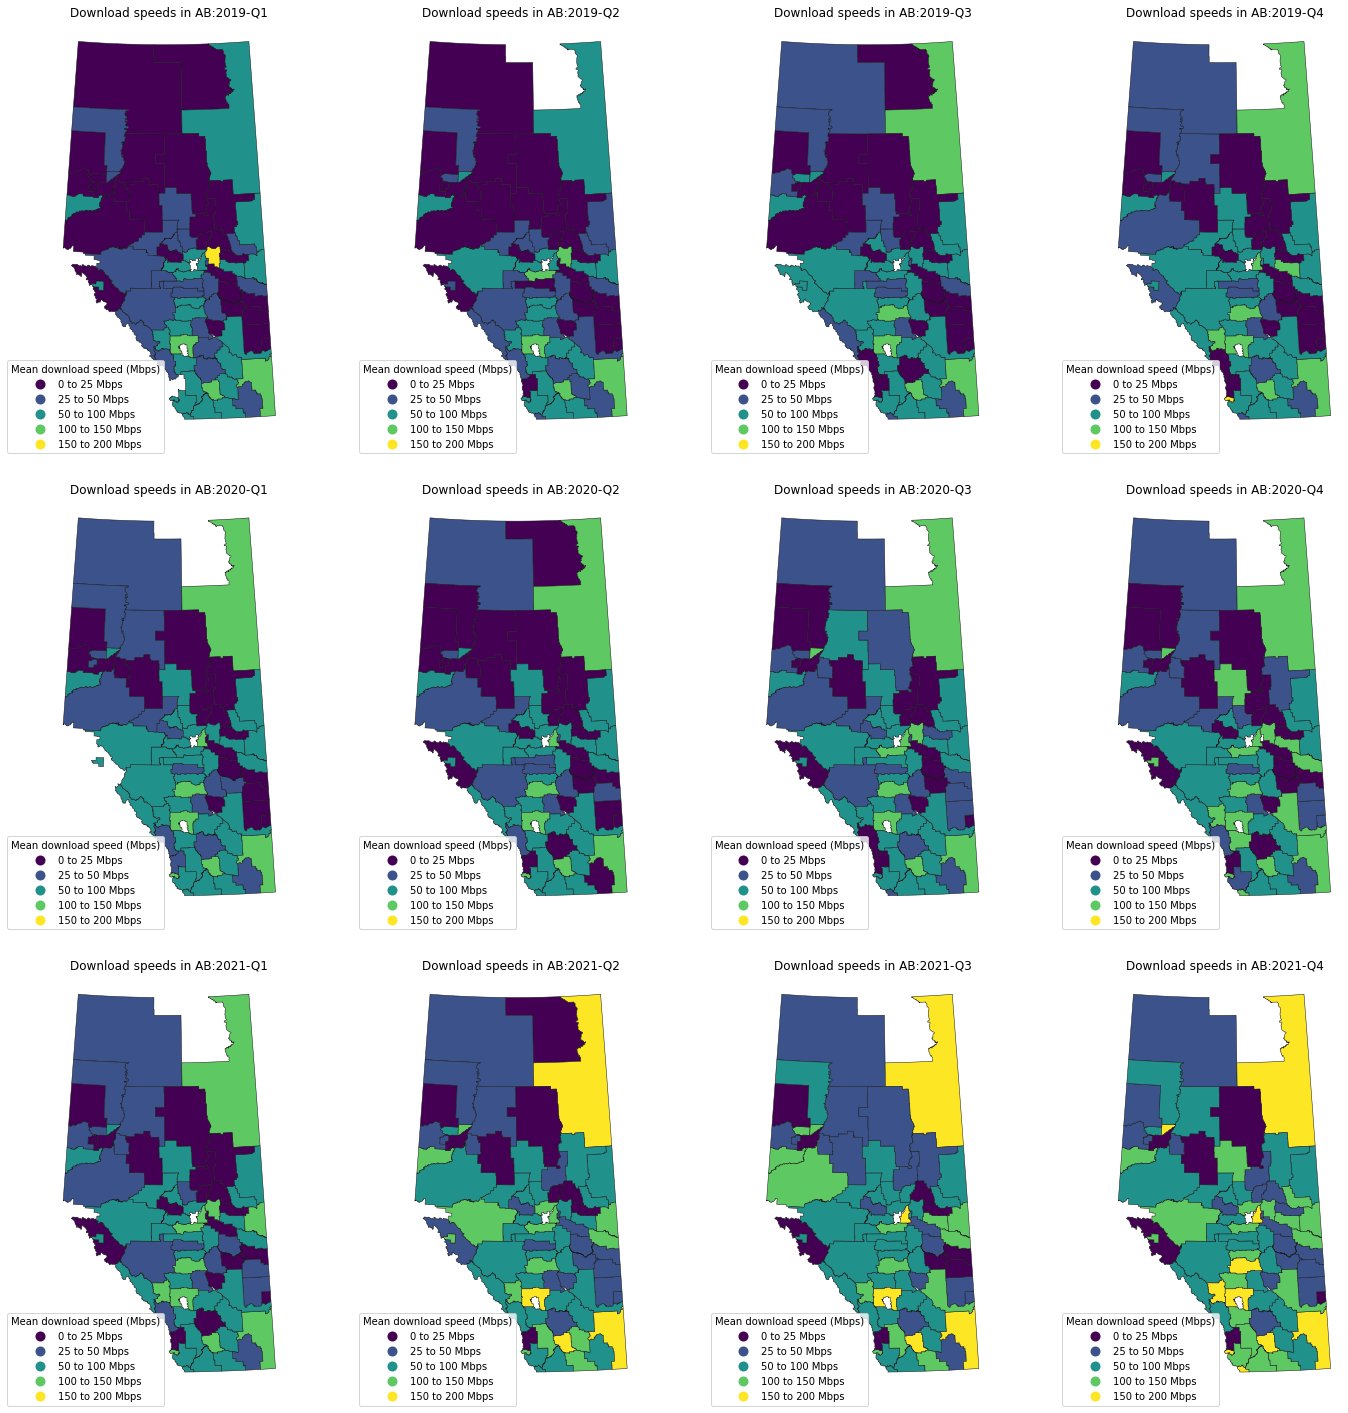

In [46]:
#### Plotting stage: detailed map

# with open('./Alberta/AB_yq_data_by_municipalities.p', 'rb') as f:
#     i_yq_data = pickle.load(f)

province = 'Alberta'
province_short = 'AB'
years = ['2019', '2020', '2021']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

fig, axs = plt.subplots(len(years),len(quarters), figsize = (20, 20))

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        df_name = str(year) + '-' + str(quarter)
        i_county_data = i_yq_data[df_name]
        i_ax = axs[i, j]
        i_county_data.plot(column='group1', cmap='viridis', linewidth=0.5, ax=i_ax, edgecolor='0.1', legend=True)
        i_ax.axis('off')
        fig_title = 'Download speeds in ' + province_short + ':' + df_name
        i_ax.set_title(fig_title)
        leg = i_ax.get_legend()
        leg.set_bbox_to_anchor((0.5, 0.2))
        leg.set_title('Mean download speed (Mbps)')
fig.tight_layout()
plt.show()


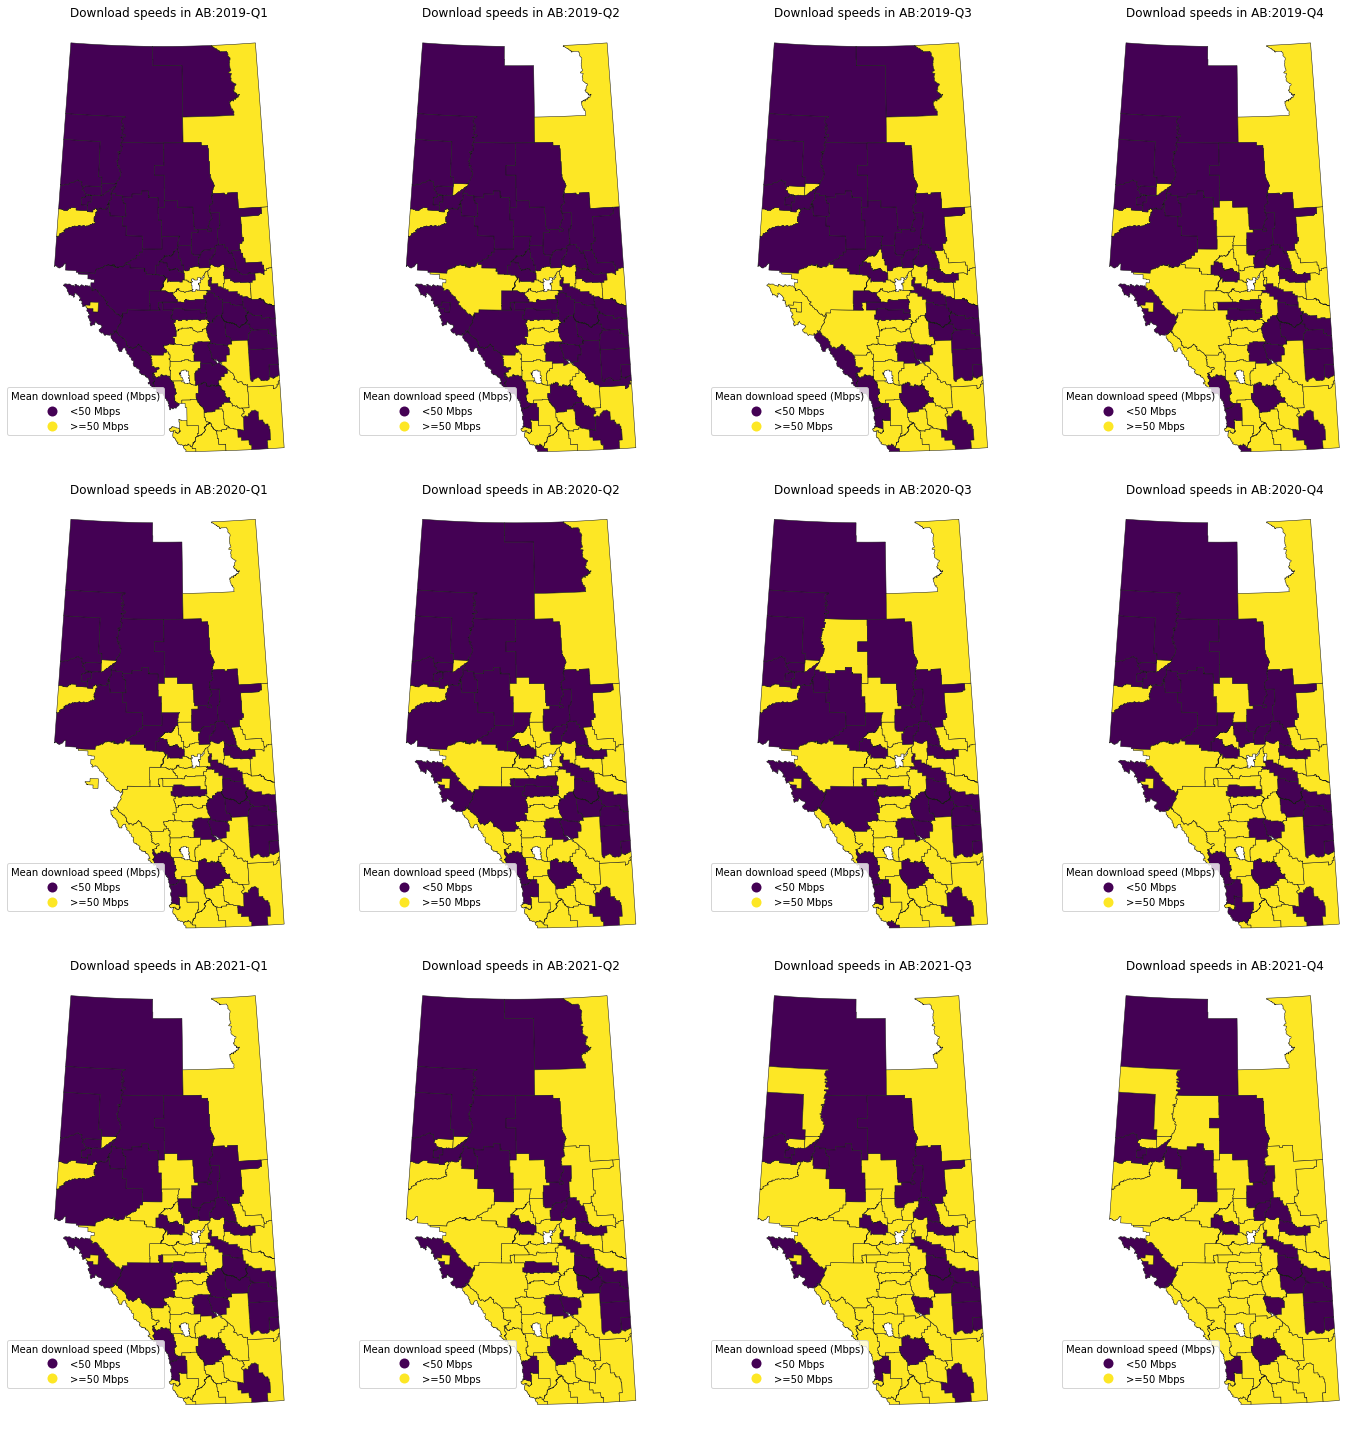

In [47]:
#### Plotting stage: binary map

# with open('./Alberta/AB_yq_data_by_municipalities.p', 'rb') as f:
#     i_yq_data = pickle.load(f)

province = 'Alberta'
province_short = 'AB'
years = ['2019', '2020', '2021']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

fig, axs = plt.subplots(len(years),len(quarters), figsize = (20, 20))

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        df_name = str(year) + '-' + str(quarter)
        i_county_data = i_yq_data[df_name]
        i_ax = axs[i, j]
        i_county_data.plot(column='group2', cmap='viridis', linewidth=0.5, ax=i_ax, edgecolor='0.1', legend=True)
        i_ax.axis('off')
        fig_title = 'Download speeds in ' + province_short + ':' + df_name
        i_ax.set_title(fig_title)
        leg = i_ax.get_legend()
        leg.set_bbox_to_anchor((0.5, 0.2))
        leg.set_title('Mean download speed (Mbps)')
fig.tight_layout()
plt.show()
